In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
tf.config.list_physical_devices('GPU')
import plotly.io as pio
import os
import shutil
import plotly.graph_objs as go
from ipywidgets import Output, VBox
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense,Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

TensorFlow version: 2.12.0


In [2]:
#pip install -U kaleido PyPDF2

In [3]:
labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] == 'None']
len(labels)

27

In [4]:
labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] != 'None']
len(labels)

93

# KLARLACK

In [5]:
df_csv = pd.read_csv('2023_10_17_icps_product_id_404_run_id_794_experiment_id_1_to_12.csv', skiprows = 7)

labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] != 'None']
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

df_csv = df_csv.rename(columns={'Product ID [  ]': 'product_id', 'Run ID [  ]': 'run_id', 'Experiment ID [  ]': 'experiment_id',
                    'Trial ID [  ]': 'trial_id', 'x-Position [ m ]': 'x_position', 'x-Force [ N ]': 'x_force'
                    , 'y-Force [ N ]': 'y_force', 'z-Force [ N ]': 'z_force'})

df_csv1 = df_csv[df_csv["product_id"] == 404]
df_csv1 = df_csv[df_csv["run_id"] == 794]

df_csv2 = df_csv[df_csv["product_id"] == 404]
df_csv2 = df_csv[df_csv["run_id"] == 795]
df_csv2["run_id"] = 794
df_csv2["experiment_id"] = 4
df_csv = pd.concat([df_csv1, df_csv2])

df_csv = df_csv[df_csv["product_id"] == 404]
df_csv = df_csv[df_csv["run_id"] == 794]

peak_dfs = []
for run_id in df_csv["run_id"].unique():
    df_temp2 = df_csv[df_csv["run_id"] == run_id]
    
    for experiment_id in df_temp2["experiment_id"].unique():
        df_temp3 = df_temp2[df_temp2["experiment_id"] == experiment_id]
        
        for trial_id in df_temp3["trial_id"].unique():
            df_temp4 = df_temp3[df_temp3["trial_id"] == trial_id]
            
            if len(df_temp4) > 1:
                peak_dfs.append(df_temp4[["run_id", "experiment_id", "trial_id", 'x_position', 'x_force', 'y_force', 'z_force']])            
print("1", len(peak_dfs))
filtered_peak_dfs = []
for i, item in enumerate(peak_dfs):
    flipped_df = item[::-1]
    filtered_df_temp = flipped_df[flipped_df['x_position'] > 20.0001].reset_index(drop=True)
    
    if len(filtered_df_temp) > 0:
        
        peak_row_temp = filtered_df_temp['x_position'].idxmax()
        
        peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
        
        filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
        filtered_df_temp2 = filtered_df_temp2[::-1]
        condition = filtered_df_temp2['x_force'] >= 0
        
        extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
        if (extracted_rows['x_position'] >= 99.9).all():
            filtered_peak_dfs1.append(pd.concat([peak_row_data_temp, extracted_rows]))
        else:
            filtered_peak_dfs.append(peak_row_data_temp)  
        #filtered_peak_dfs.append(filtered_df_temp2)    
print("2", len(filtered_peak_dfs))


max_length = max(len(df) for df in filtered_peak_dfs)
print(max_length)
for idx, df in enumerate(filtered_peak_dfs):
    if len(df) == max_length:
        max_df_id = idx
        break
max_length_df = filtered_peak_dfs[max_df_id]
print("max df id", max_df_id)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    if padding_size >= 0:
        try:
            padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
        except:
            pass
        padded_df['index'] = padded_df.index
    else:
        padded_df = df.sample(n=519, random_state=42).sort_index()
    padded_dataframes.append(padded_df.reset_index(drop=True))

93


<ipython-input-5-66d79b696d87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["run_id"] = 794
<ipython-input-5-66d79b696d87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["experiment_id"] = 4


1 120
2 120
555
max df id 68


109
519


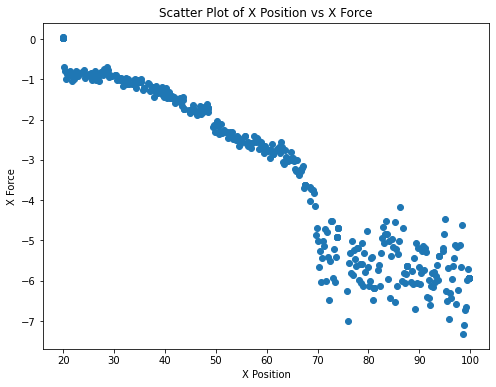

In [6]:
random_number = random.randint(0, len(padded_dataframes) - 1)  # assuming padded_dataframes is a list or a compatible data structure
print(random_number)
df_show = padded_dataframes[random_number]
print(len(df_show))

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(df_show["x_position"], df_show["x_force"])
plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot of X Position vs X Force')
plt.show()

In [7]:
lengths = set()
padded_dataframes_with_labels = []
for item in padded_dataframes:
    lengths.add(len(item))
    
    run_id = item["run_id"].unique()[0],
    trial_id = item["trial_id"].unique()[0],
    experiment_id = item["experiment_id"].unique()[0]
    
    #print("RUN_ID:", run_id,"experiment_id:",  experiment_id,"trial_id:", trial_id)

    individual = labels[labels["run_id"] == run_id]
    individual = individual[individual["experiment_id"] == experiment_id]
    individual = individual[individual["trial_id"] == trial_id]
    try:
        individual['row'].iloc[0].isnumeric()
    except:
        continue
    if individual['row'].iloc[0].isnumeric():
        row_value = int(individual['row'])
        padded_dataframes_with_labels.append((item, row_value))
    else:
        continue
print(lengths)
print(len(padded_dataframes_with_labels))

{519}
93


281


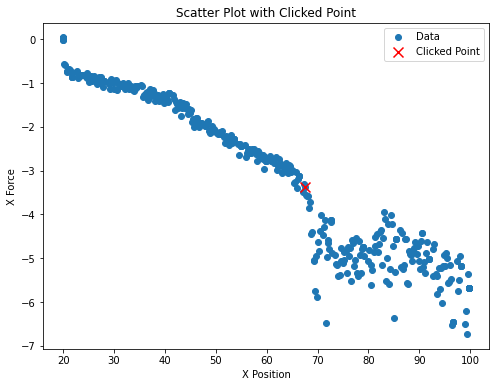

In [8]:
random_number = random.randint(0, len(padded_dataframes_with_labels) - 1)
df_show = padded_dataframes_with_labels[random_number][0]
label = padded_dataframes_with_labels[random_number][1]
print(label)

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Scatter plot of the data
plt.scatter(df_show["x_position"], df_show["x_force"], label='Data')

# Get the target row based on the label
target_row = df_show.iloc[label]

# Plot the clicked point as a red 'X'
plt.scatter(target_row["x_position"], target_row["x_force"], color='red', marker='x', s=100, label='Clicked Point')

plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot with Clicked Point')
plt.legend()
plt.show()

# ML

In [9]:
#padded_dataframes_with_labels_combined[1][0]

In [10]:
tensor_X = []
tensor_y = []
for item in padded_dataframes_with_labels:
    #df_temp = item[0][['x_force', 'y_force', 'z_force']].copy()
    #df_temp = item[0][['x_force', 'z_force']].copy()
    df_temp = item[0][['x_force']].copy()
    a = df_temp.to_numpy().astype(np.float32)
    tensor_X.append(a)
    tensor_y.append(item[1])
print(len(tensor_X))
print(len(tensor_y))

# train test split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(tensor_X), np.array(tensor_y), test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.9, shuffle=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape , y_val.shape)

93
93
(74, 519, 1) (18, 519, 1) (74,) (18,) (1, 519, 1) (1,)


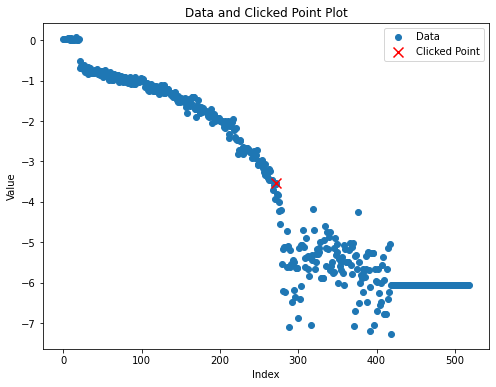

In [11]:
random_number = random.randint(0, len(tensor_X) - 1)

data = tensor_X[random_number]
y = tensor_y[random_number]

if len(data.shape) > 1:
    yo = data[:, 0]
else:
    yo = data.flatten()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Plot the lines
plt.scatter(np.arange(len(yo)), yo, label='Data')

# Plot the clicked point as a red 'X'
plt.scatter(y, data[y], color='red', marker='x', s=100, label='Clicked Point')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data and Clicked Point Plot')
plt.legend()
plt.show()

# Regression

In [12]:
random_number = random.randint(0, len(X_train)-1)
print(X_train[random_number].shape[0])
print(X_train[random_number].shape)
X_train[random_number].shape[1]

519
(519, 1)


1

In [13]:
regression_model = tf.keras.models.load_model('Polke_only_Regression_best_model.h5')

In [14]:
# Evaluate the model on the test data
loss = regression_model.evaluate(np.array(tensor_X), np.array(tensor_y))
# Print the evaluation result
print("Loss: ", loss)

3/3 [==============================] - 0s 27ms/step - loss: 740.8003
Loss:  740.80029296875


In [15]:
# Predict
print(len(tensor_X))
predictions = regression_model.predict(np.array(tensor_X))
predictions = np.round(predictions)
print(mean_squared_error(predictions, np.array(tensor_y)))
print(mean_absolute_error(predictions, np.array(tensor_y)))
# Print the arrays side by side
# for a, b in zip(predictions, np.round(np.array(tensor_y))):
#     print(f"{int(a)} {b}")

93
3/3 [==============================] - 0s 8ms/step
742.6344086021505
21.774193548387096


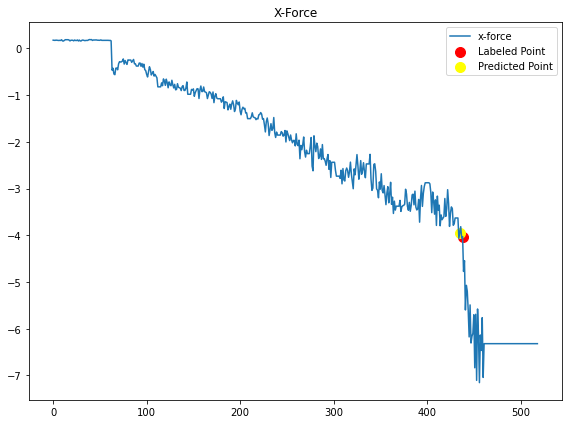

##################### NEXT #####################


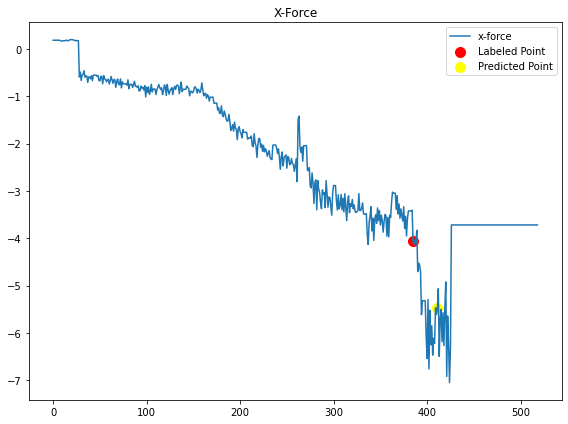

##################### NEXT #####################


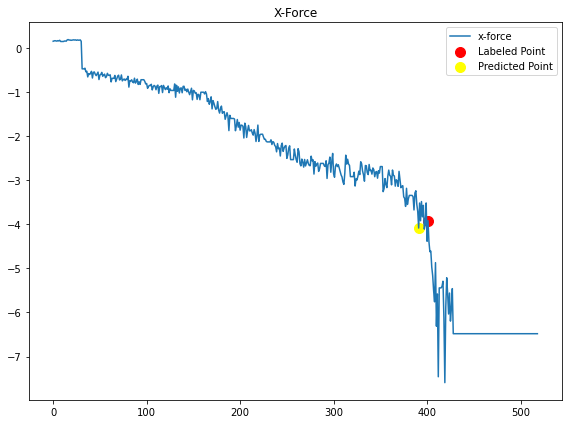

##################### NEXT #####################


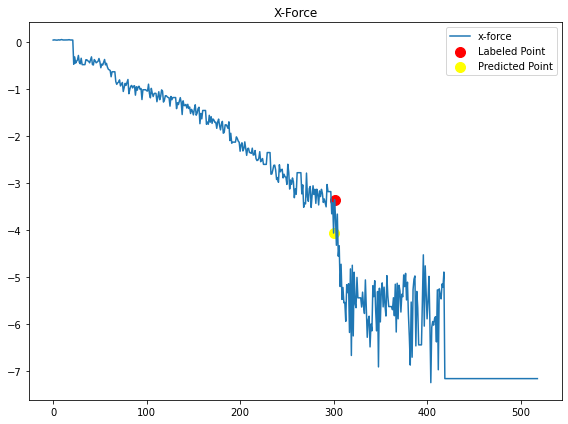

##################### NEXT #####################


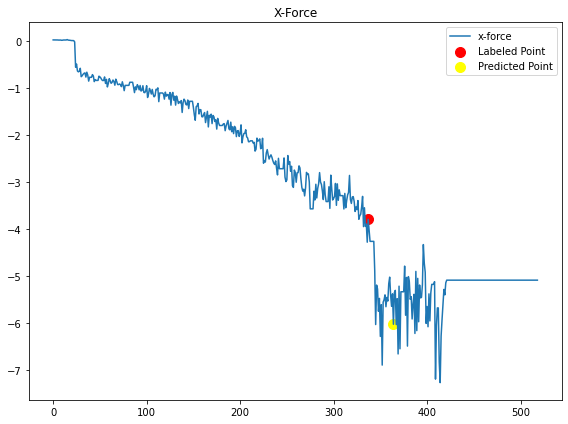

##################### NEXT #####################


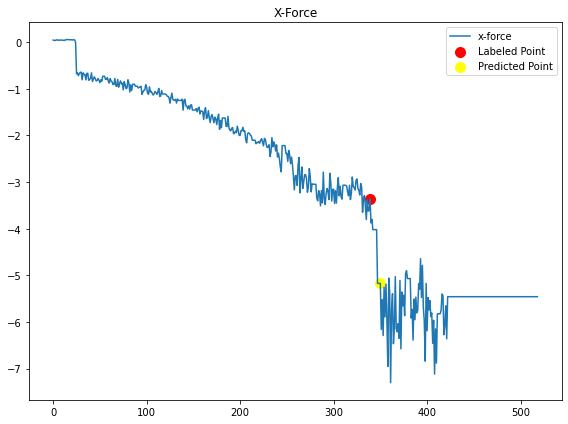

##################### NEXT #####################


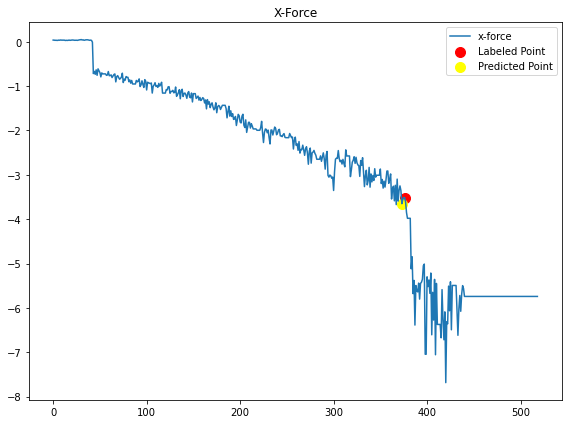

##################### NEXT #####################


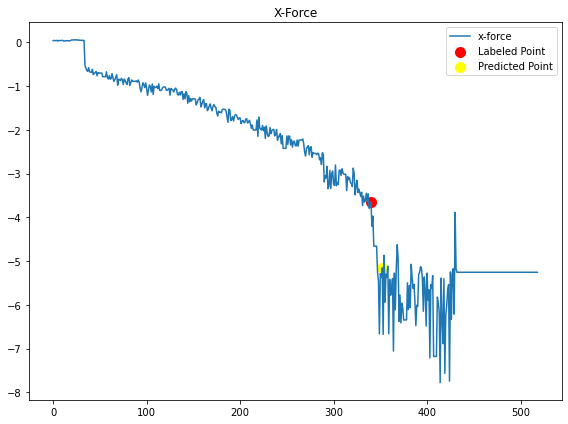

##################### NEXT #####################


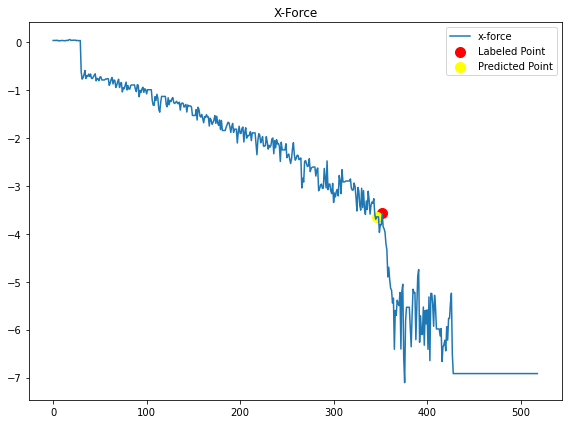

##################### NEXT #####################


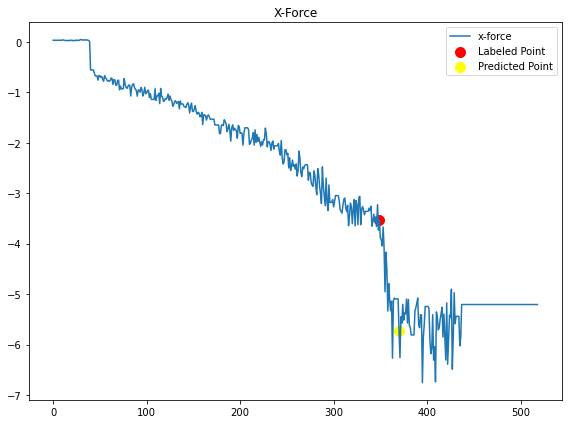

##################### NEXT #####################


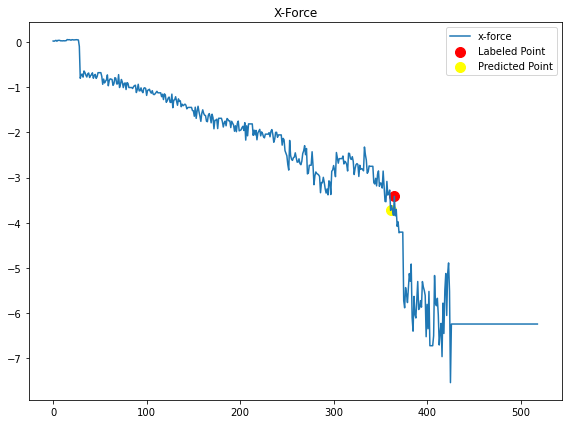

##################### NEXT #####################


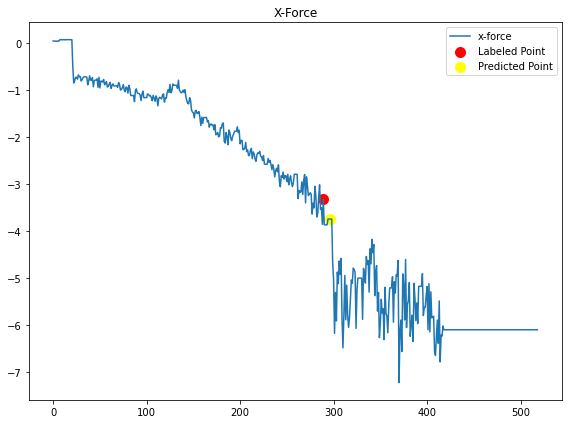

##################### NEXT #####################


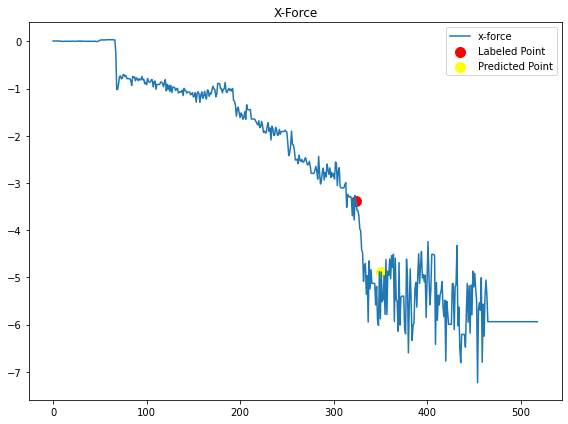

##################### NEXT #####################


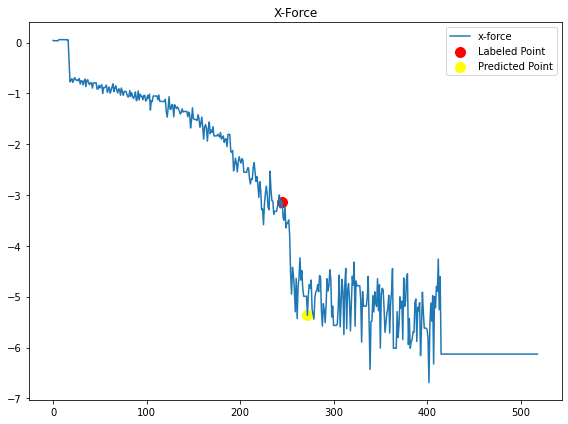

##################### NEXT #####################


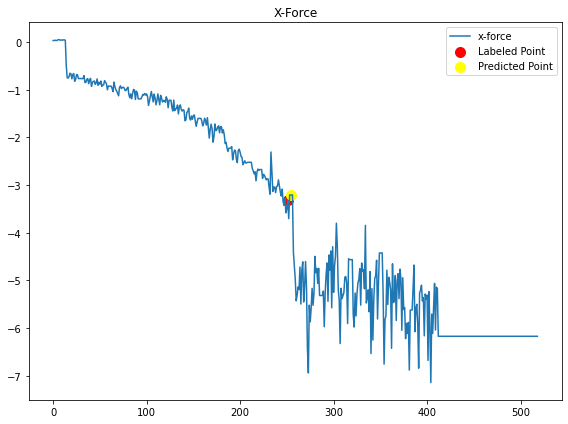

##################### NEXT #####################


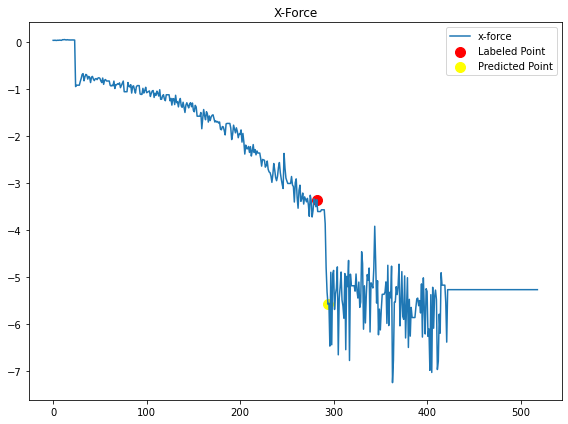

##################### NEXT #####################


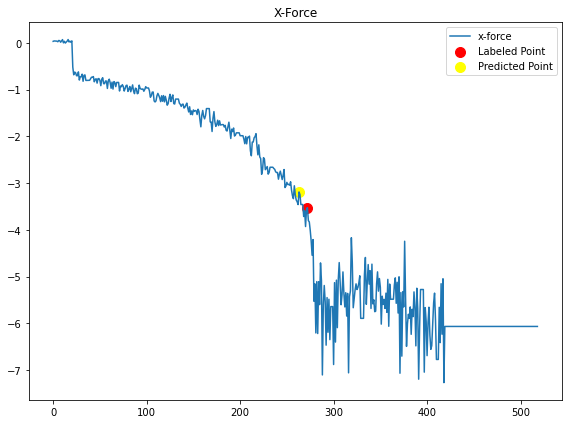

##################### NEXT #####################


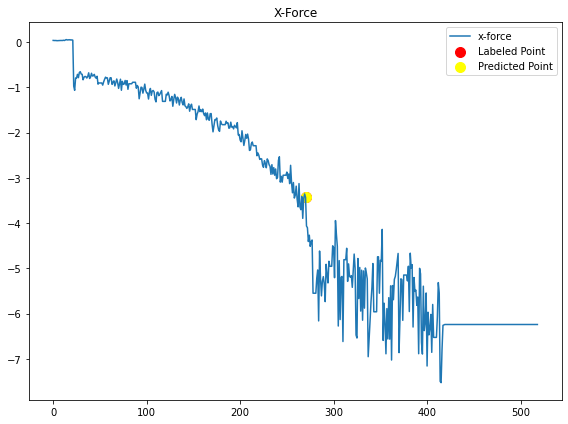

##################### NEXT #####################


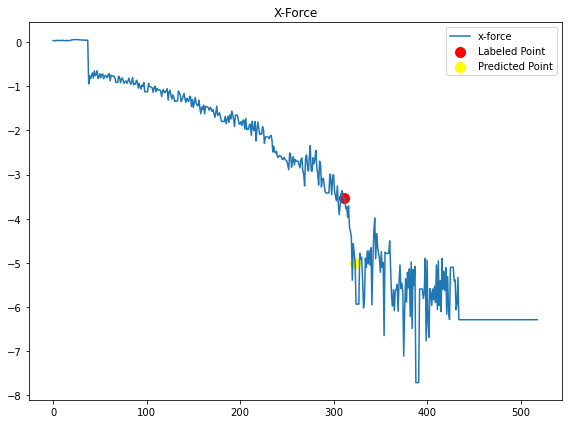

##################### NEXT #####################


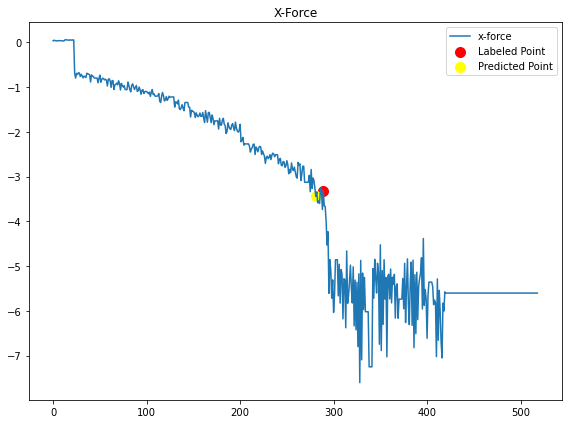

##################### NEXT #####################


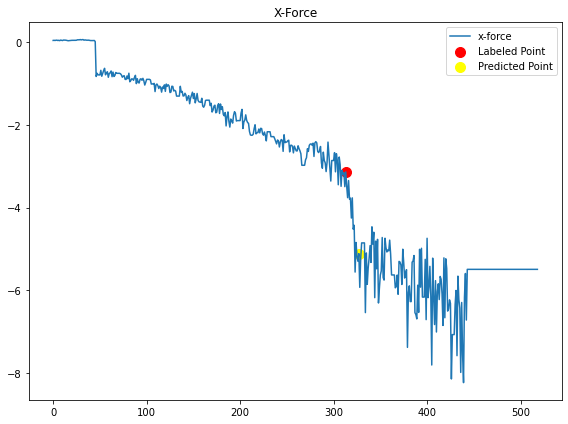

##################### NEXT #####################


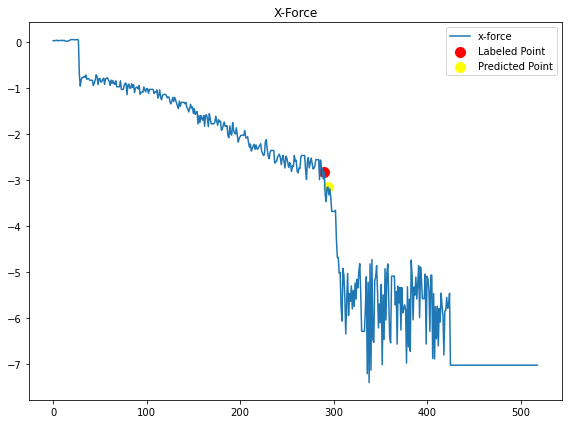

##################### NEXT #####################


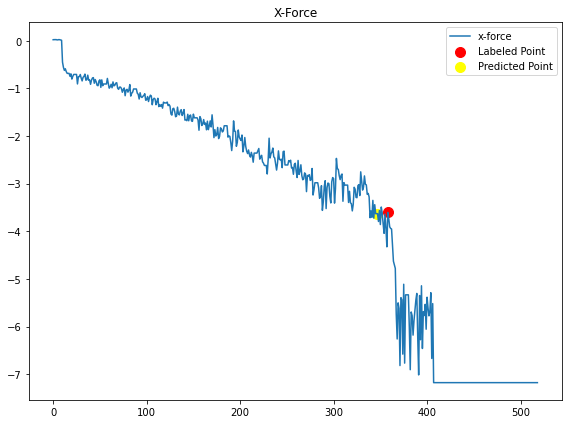

##################### NEXT #####################


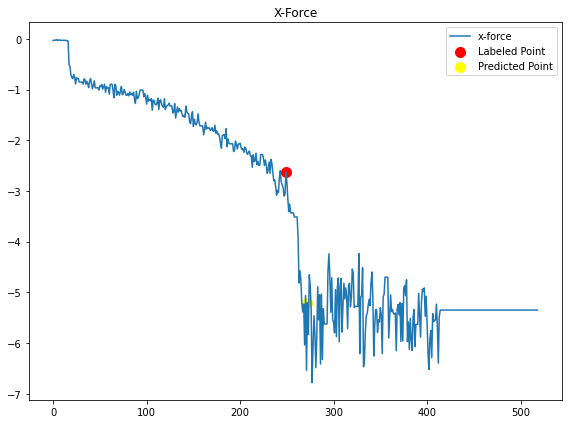

##################### NEXT #####################


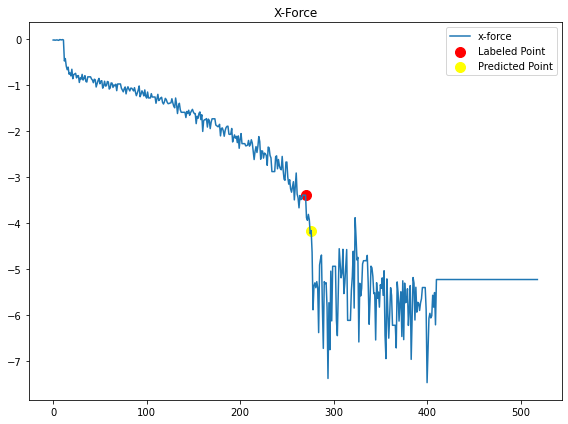

##################### NEXT #####################


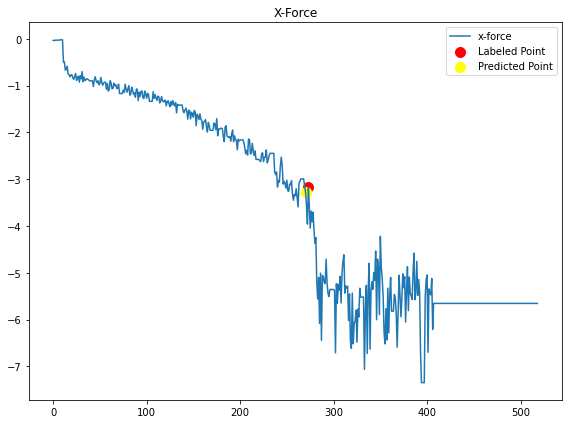

##################### NEXT #####################


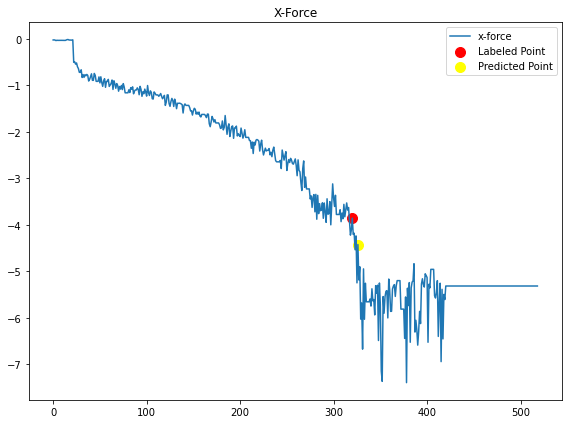

##################### NEXT #####################


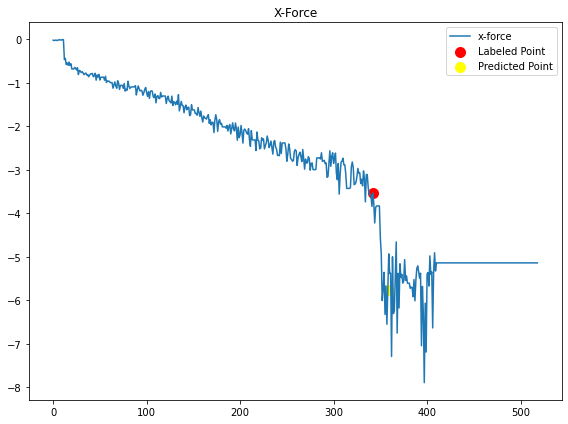

##################### NEXT #####################


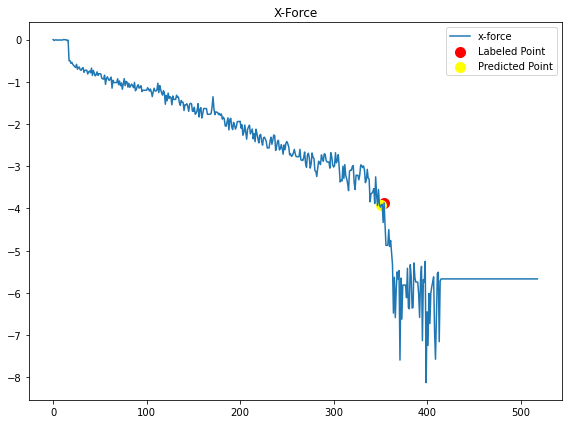

##################### NEXT #####################


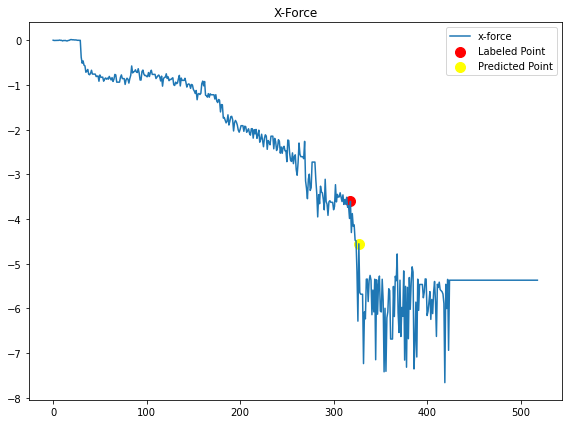

##################### NEXT #####################


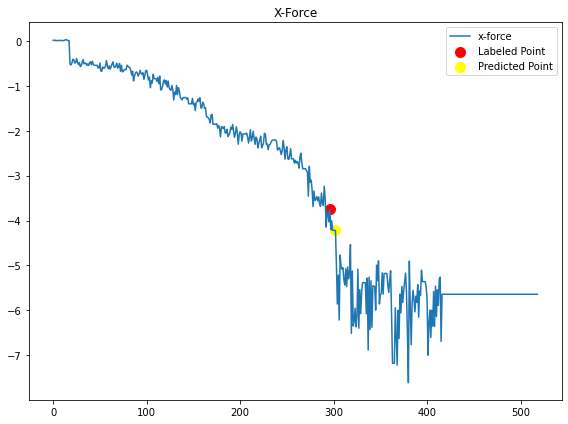

##################### NEXT #####################


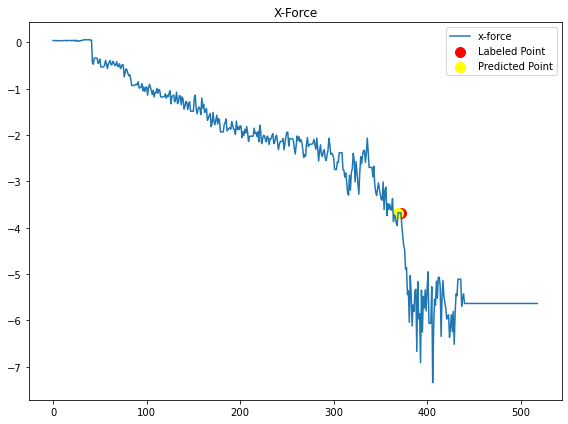

##################### NEXT #####################


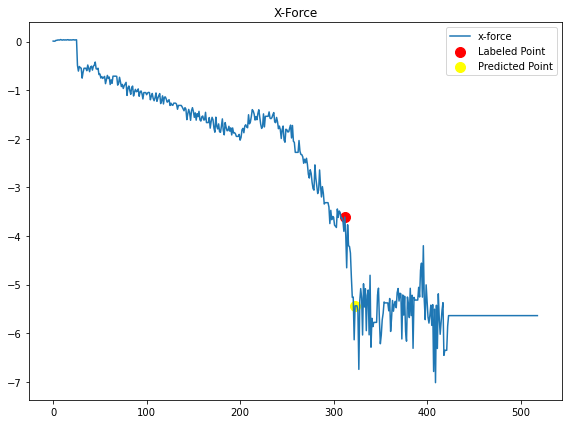

##################### NEXT #####################


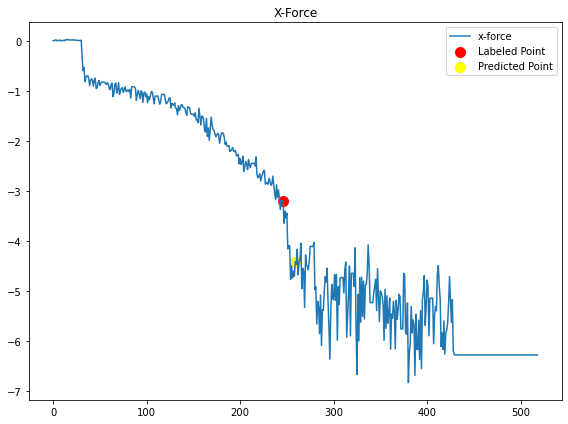

##################### NEXT #####################


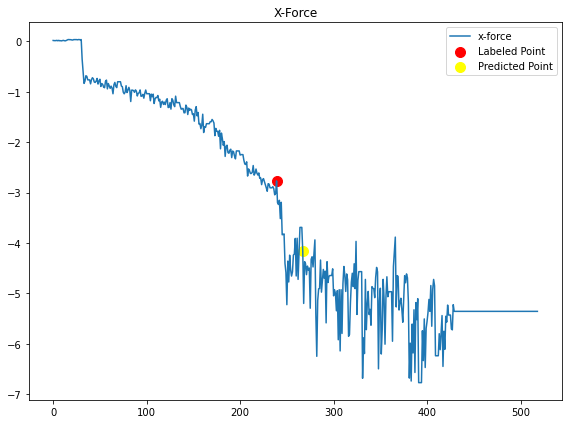

##################### NEXT #####################


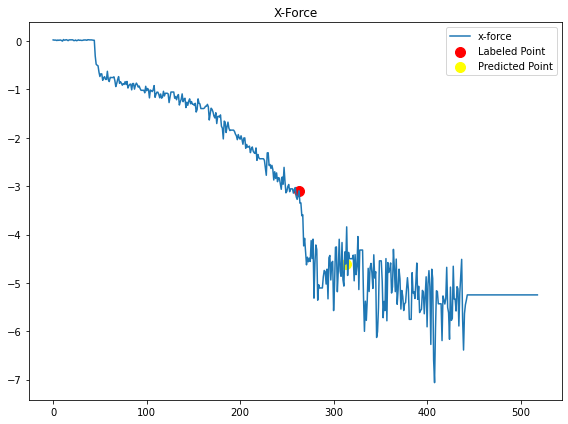

##################### NEXT #####################


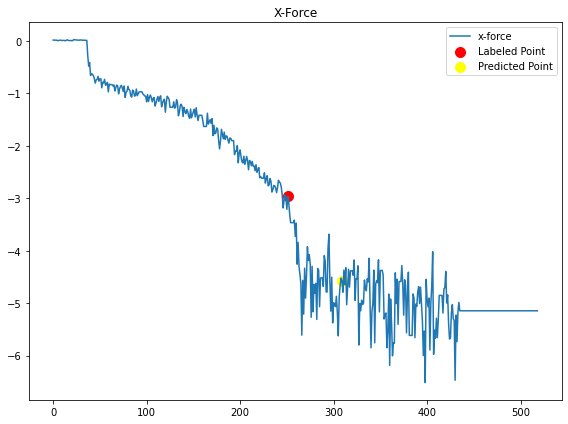

##################### NEXT #####################


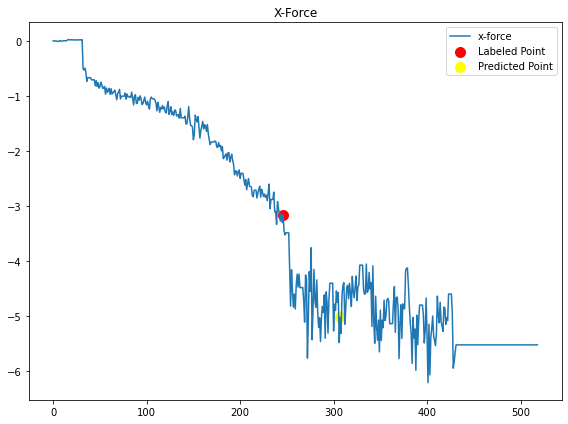

##################### NEXT #####################


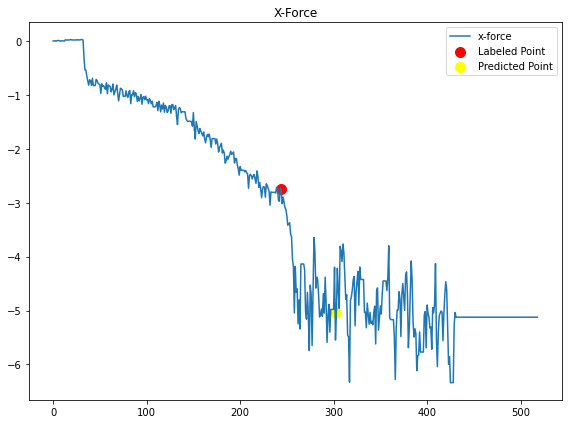

##################### NEXT #####################


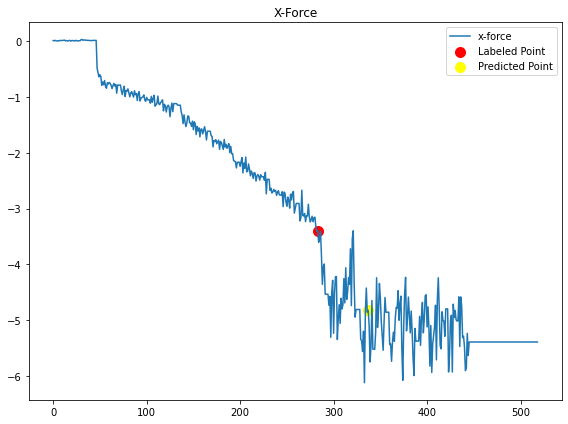

##################### NEXT #####################


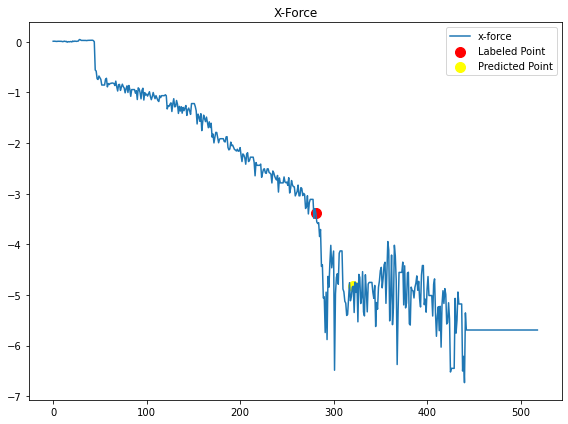

##################### NEXT #####################


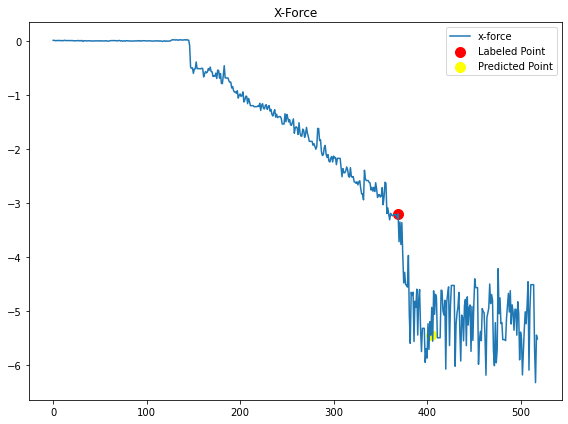

##################### NEXT #####################


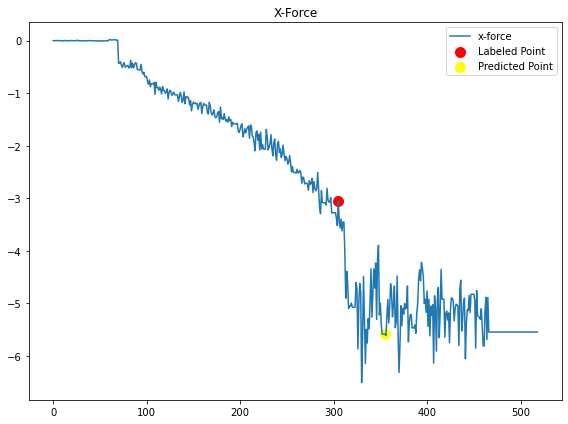

##################### NEXT #####################


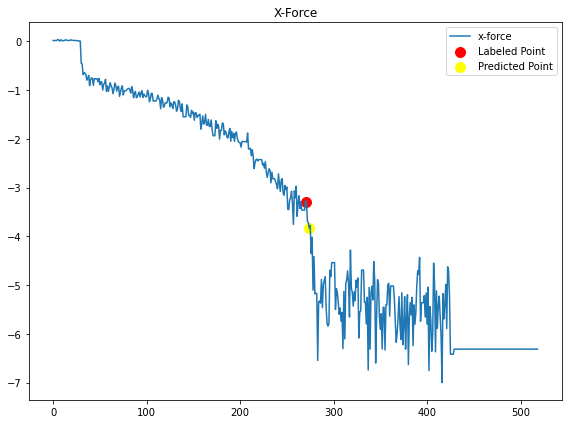

##################### NEXT #####################


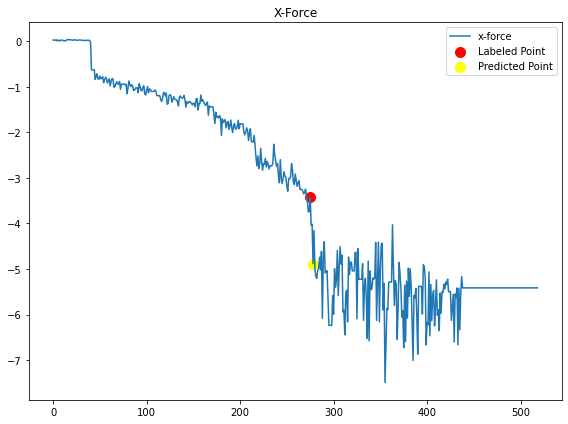

##################### NEXT #####################


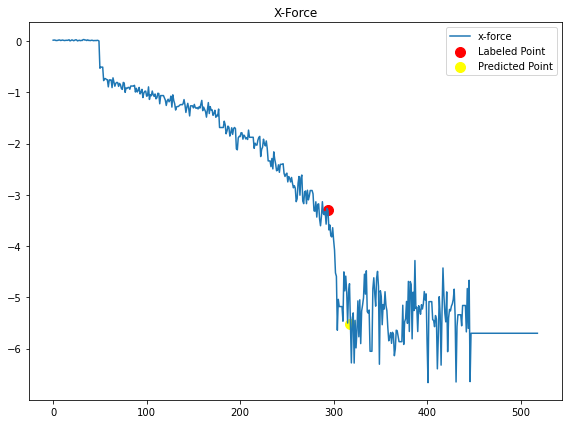

##################### NEXT #####################


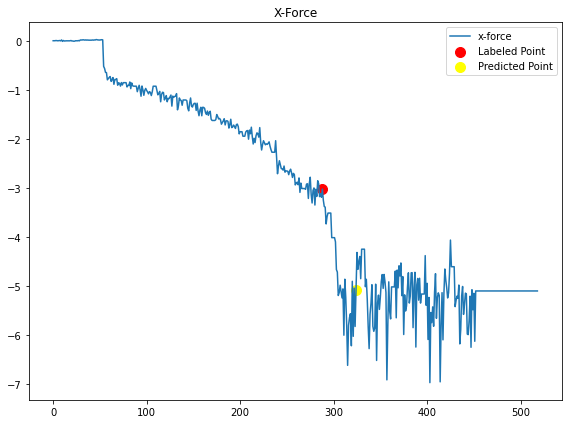

##################### NEXT #####################


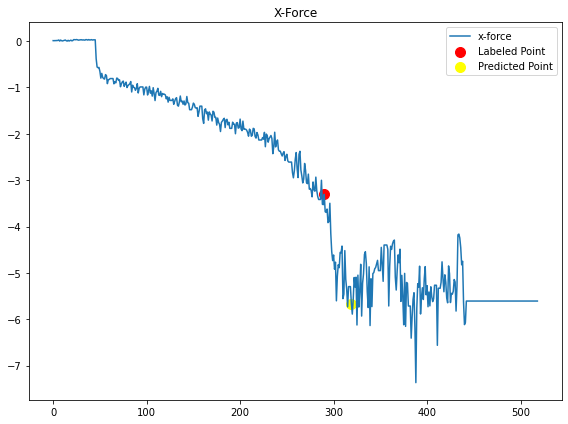

##################### NEXT #####################


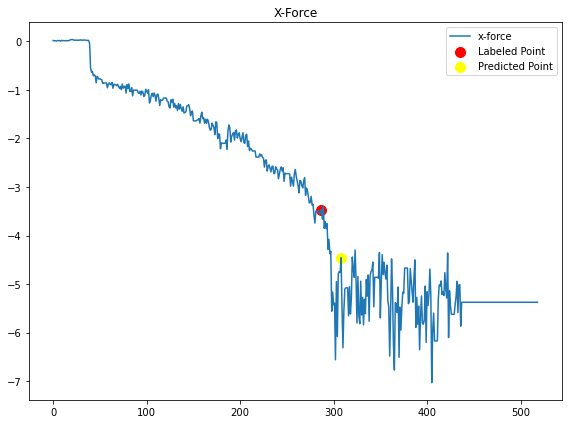

##################### NEXT #####################


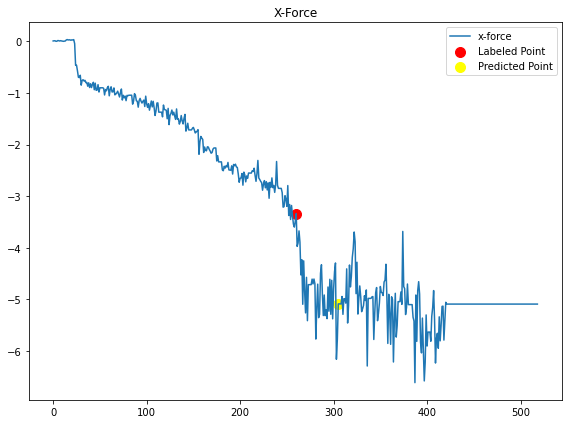

##################### NEXT #####################


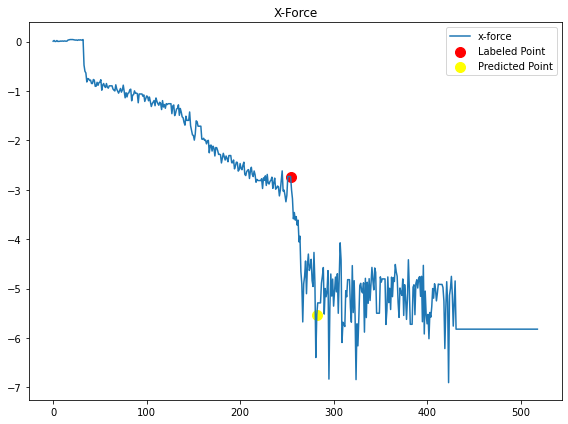

##################### NEXT #####################


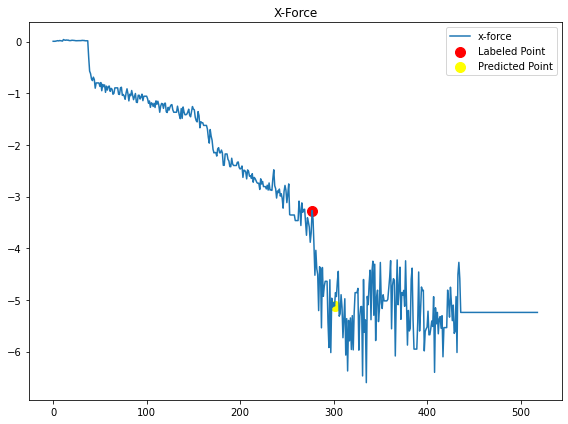

##################### NEXT #####################


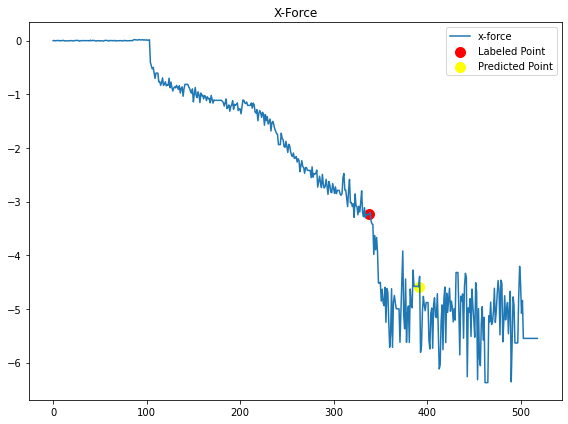

##################### NEXT #####################


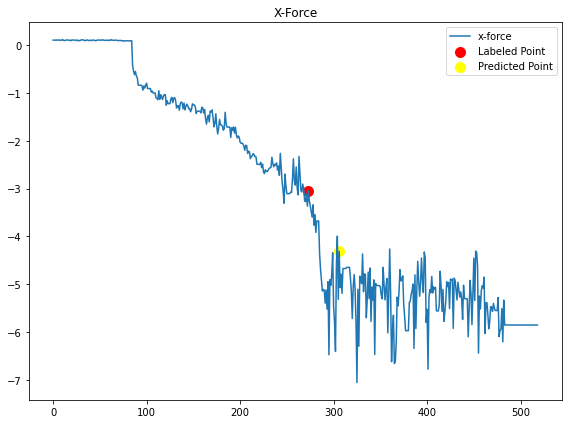

##################### NEXT #####################


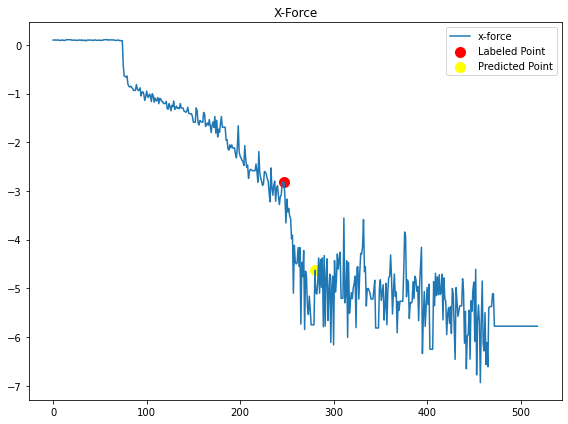

##################### NEXT #####################


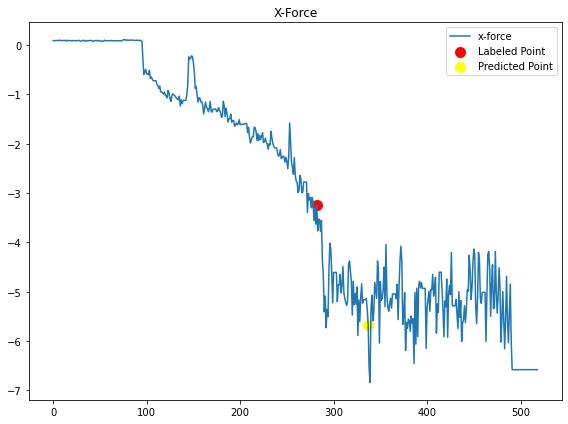

##################### NEXT #####################


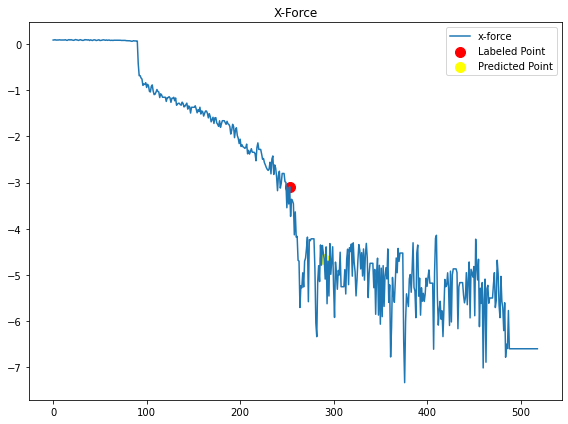

##################### NEXT #####################


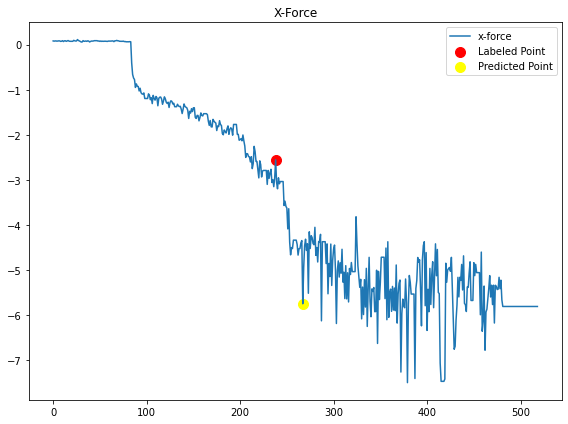

##################### NEXT #####################


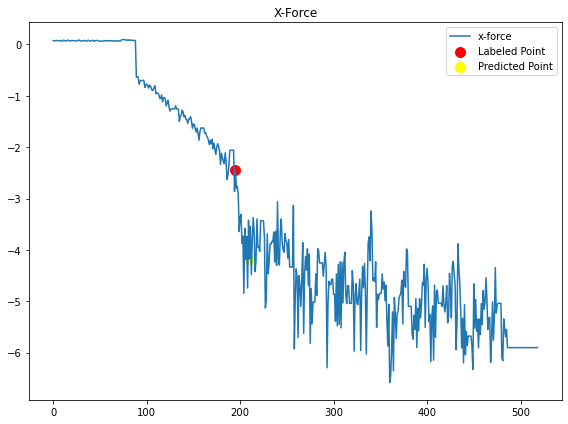

##################### NEXT #####################


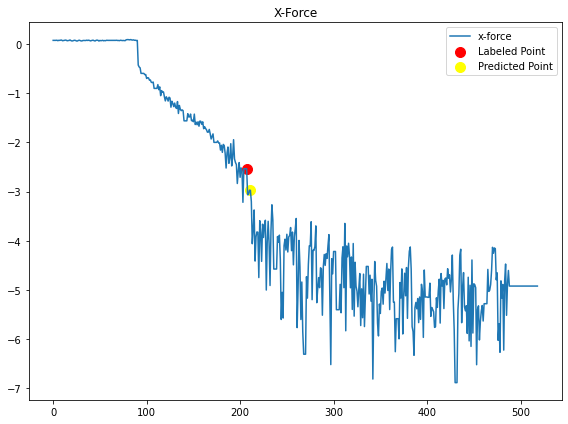

##################### NEXT #####################


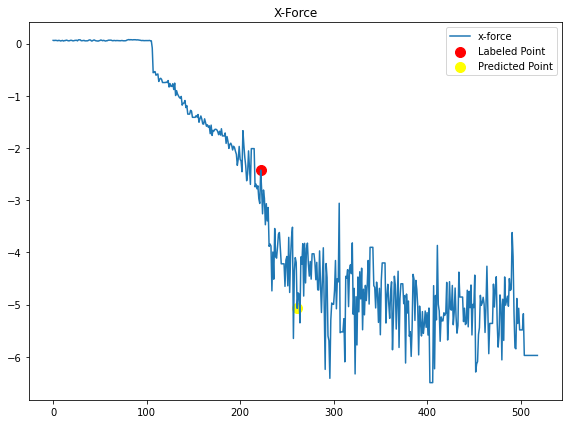

##################### NEXT #####################


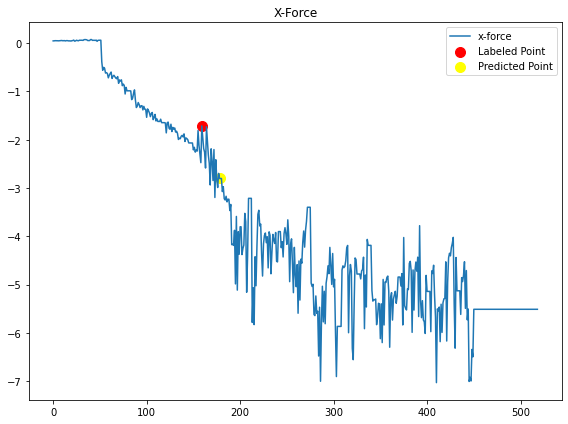

##################### NEXT #####################


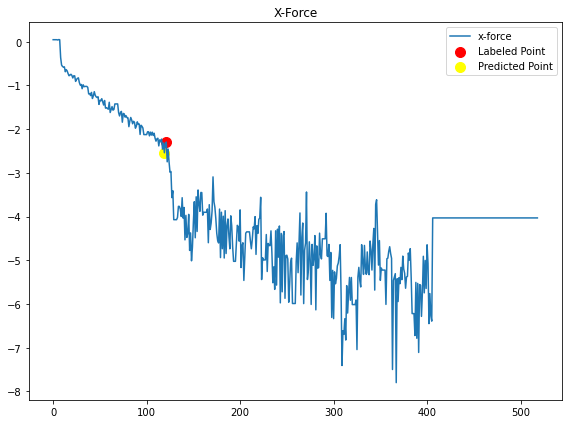

##################### NEXT #####################


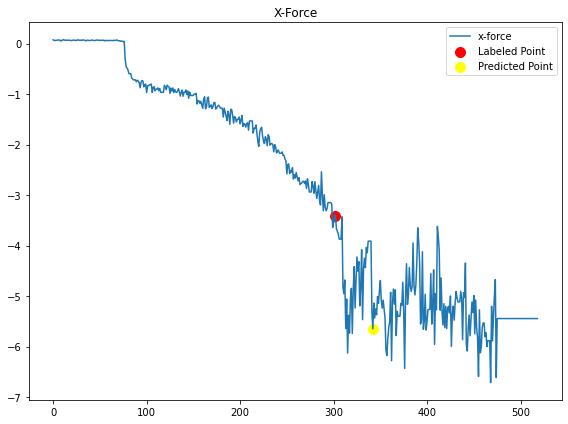

##################### NEXT #####################


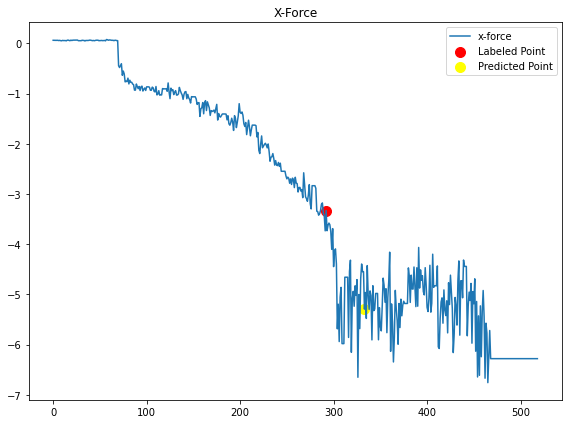

##################### NEXT #####################


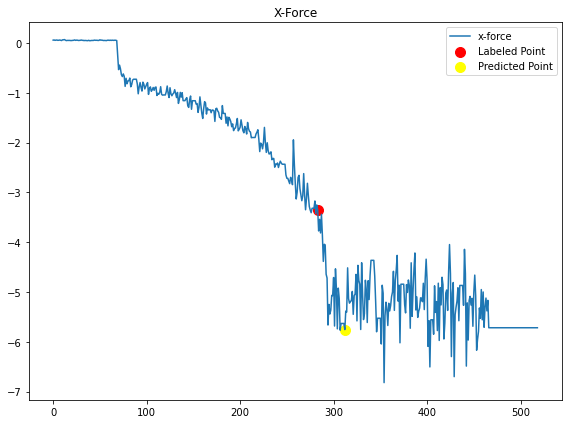

##################### NEXT #####################


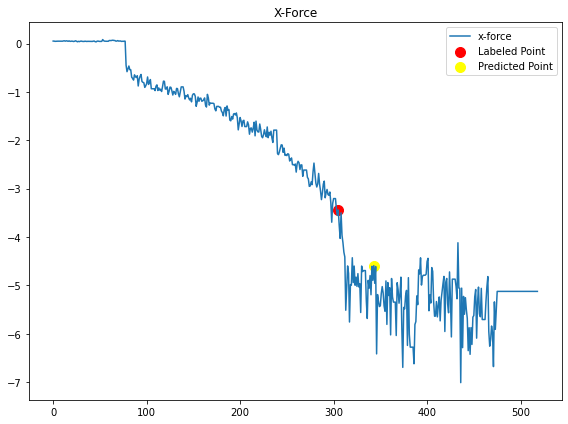

##################### NEXT #####################


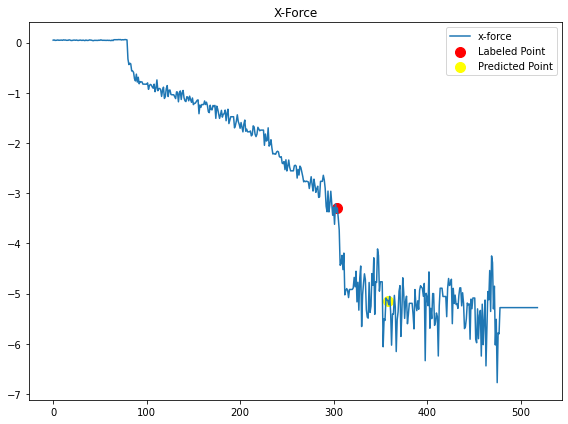

##################### NEXT #####################


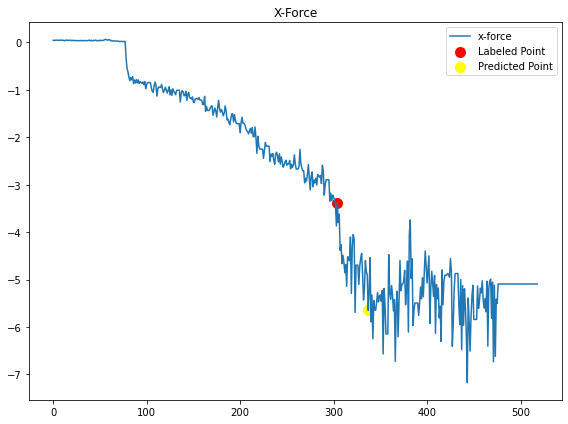

##################### NEXT #####################


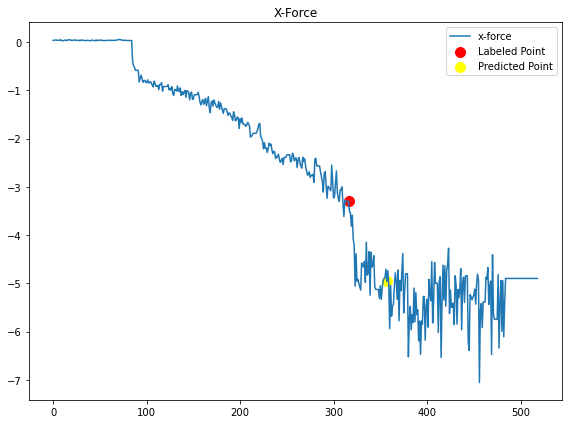

##################### NEXT #####################


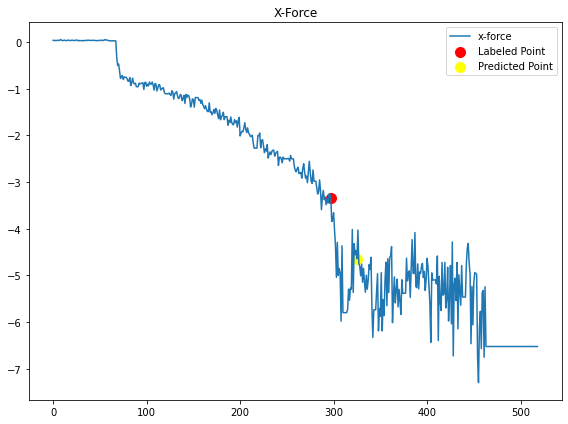

##################### NEXT #####################


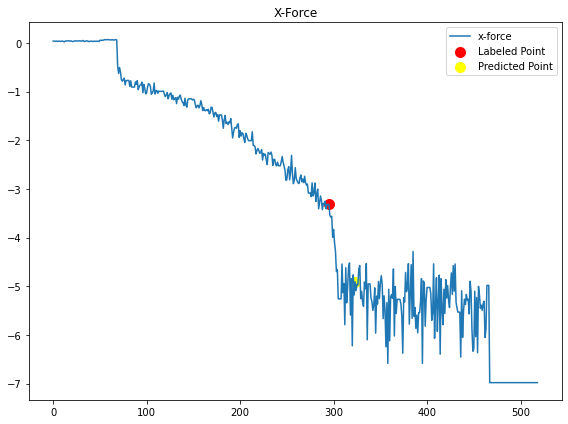

##################### NEXT #####################


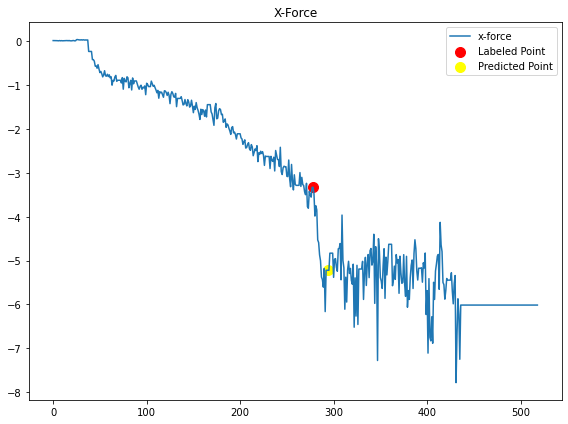

##################### NEXT #####################


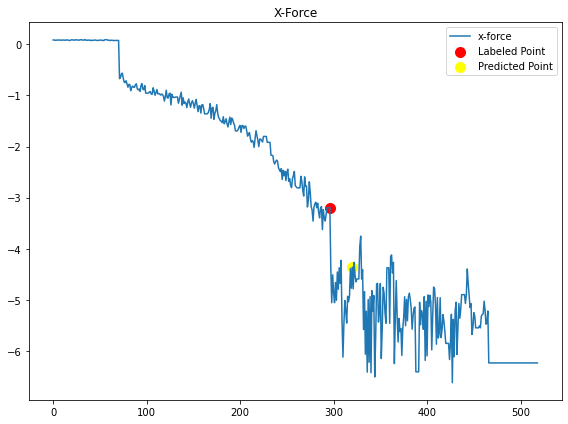

##################### NEXT #####################


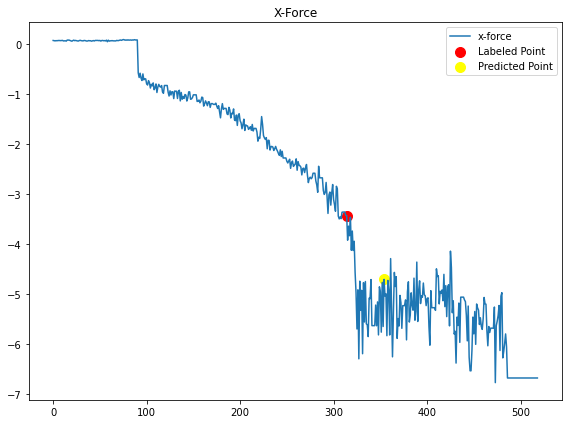

##################### NEXT #####################


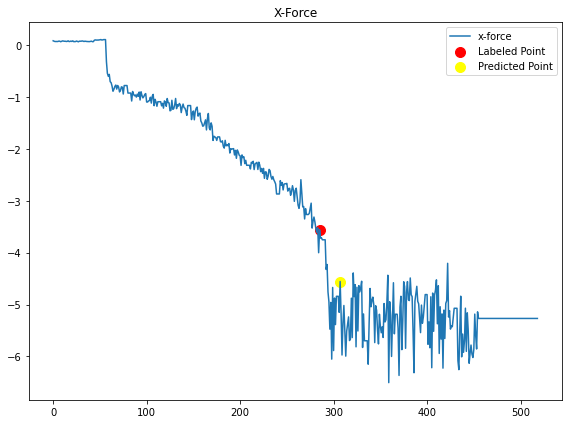

##################### NEXT #####################


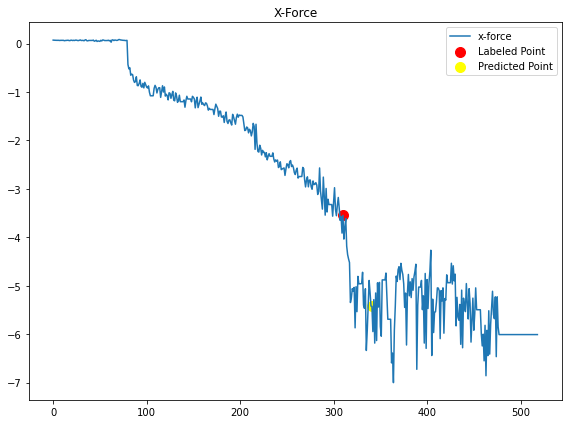

##################### NEXT #####################


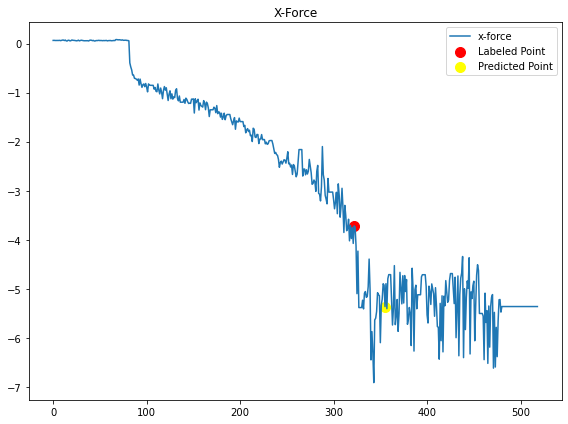

##################### NEXT #####################


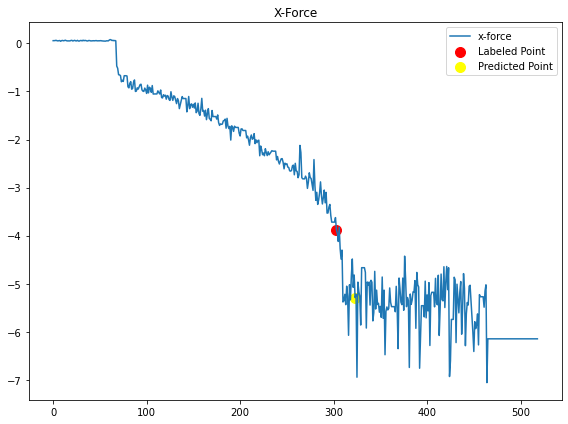

##################### NEXT #####################


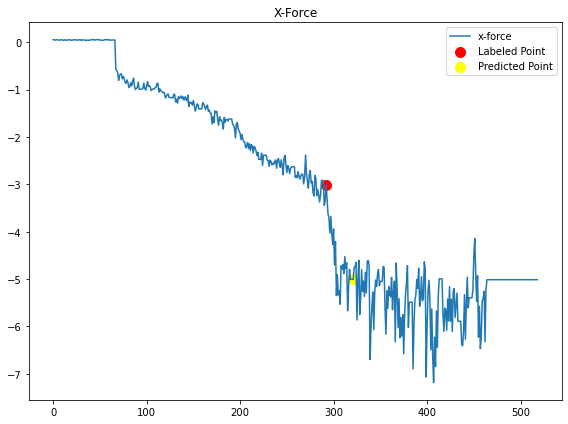

##################### NEXT #####################


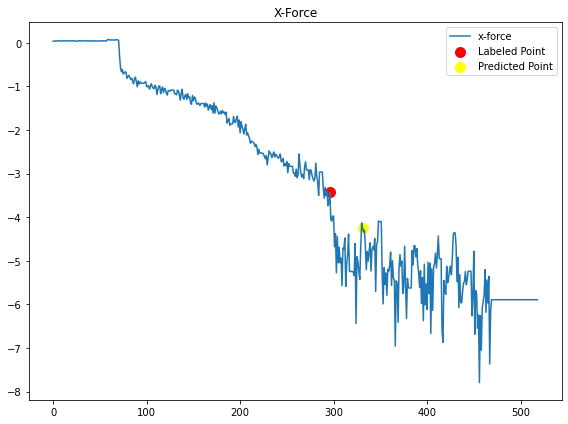

##################### NEXT #####################


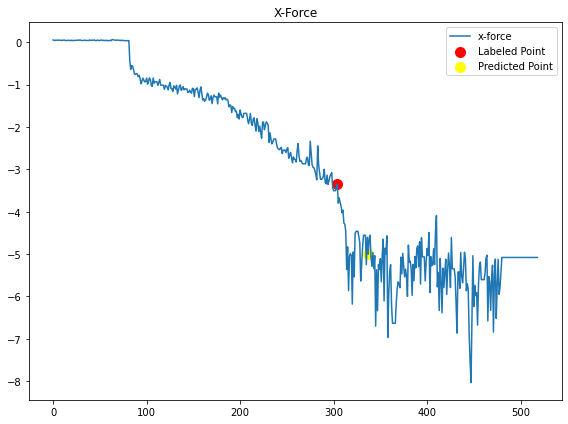

##################### NEXT #####################


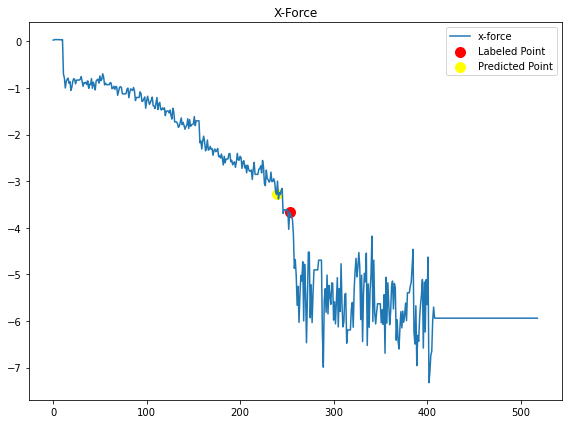

##################### NEXT #####################


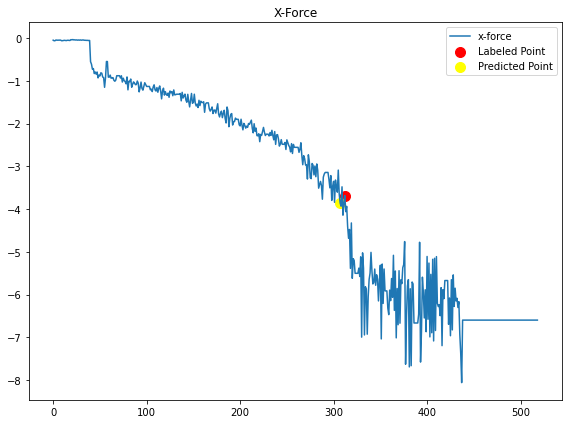

##################### NEXT #####################


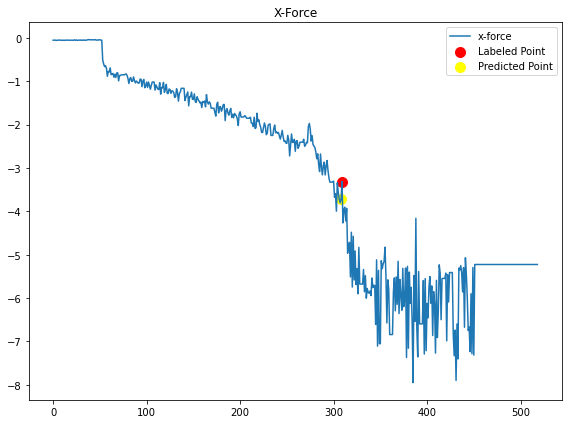

##################### NEXT #####################


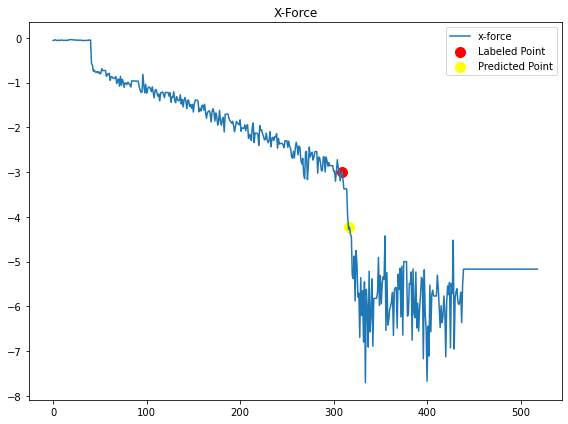

##################### NEXT #####################


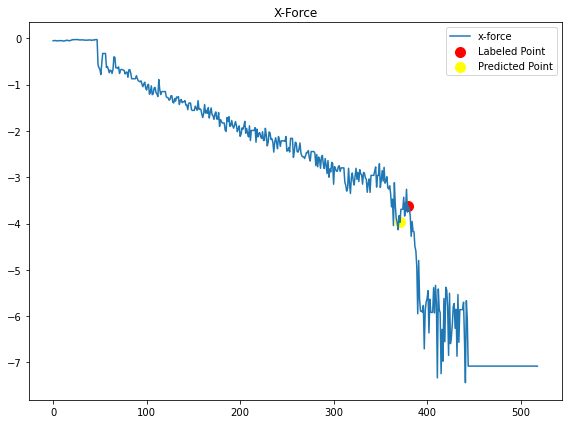

##################### NEXT #####################


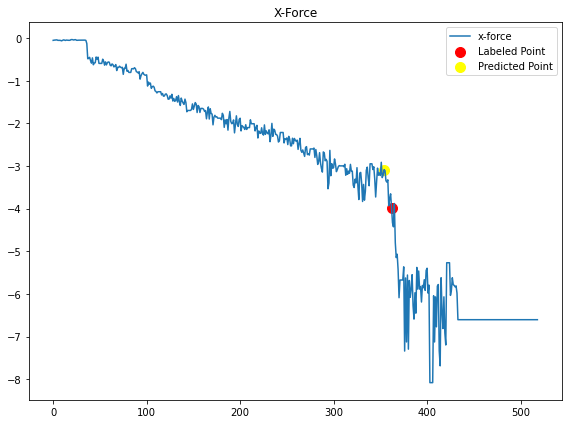

##################### NEXT #####################


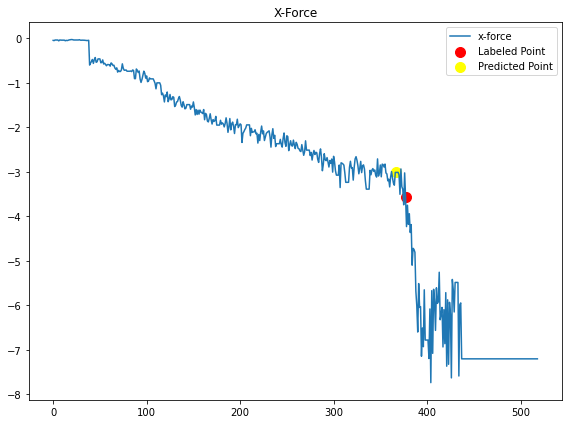

##################### NEXT #####################


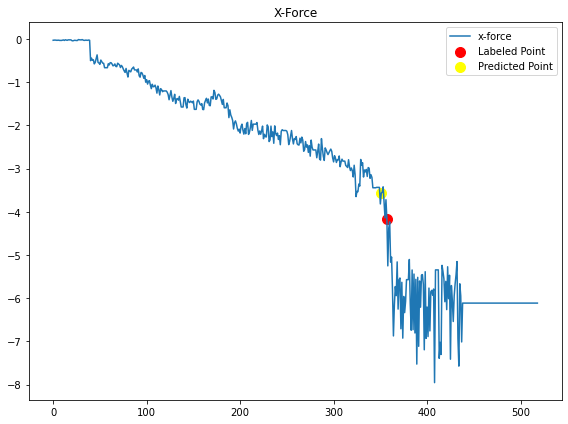

##################### NEXT #####################


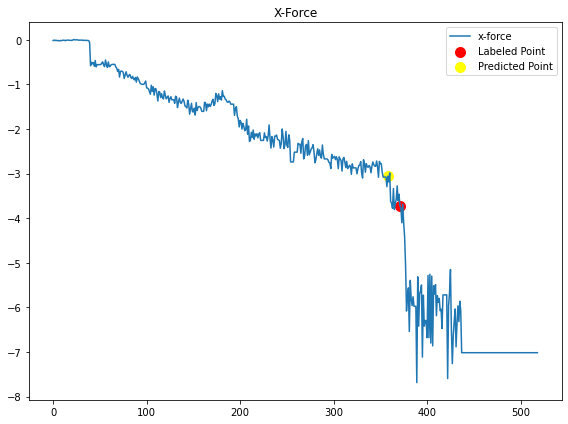

##################### NEXT #####################


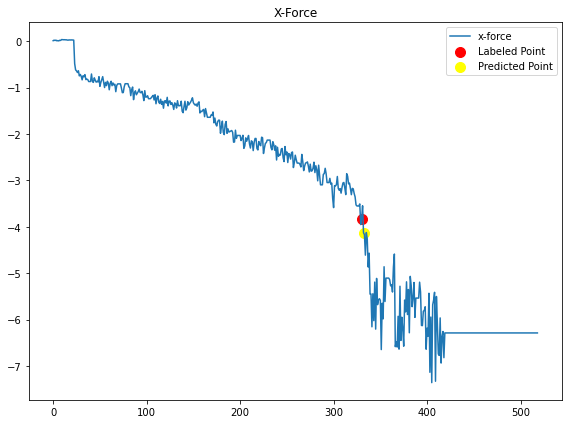

##################### NEXT #####################


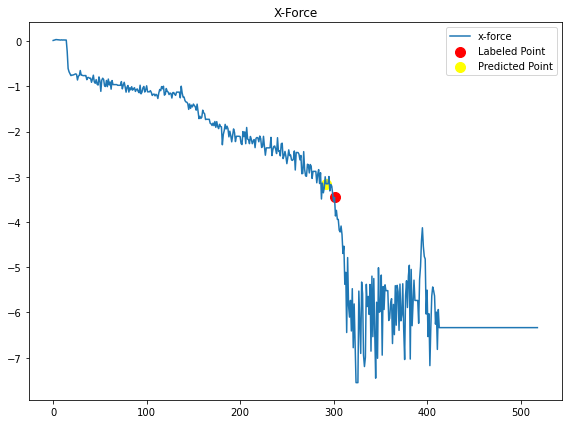

##################### NEXT #####################


In [16]:
for i, item in enumerate(predictions):
    x_force = np.array(tensor_X)[i][:, 0]
    label = np.array(tensor_y)[i]
    item = int(item[0])

    plt.figure(figsize=(8, 6))
    
    plt.plot(np.arange(len(x_force)), x_force, label='x-force')
    plt.scatter(label, x_force[label], color='red', label='Labeled Point', s=100)
    plt.scatter(item, x_force[item], color='yellow', label='Predicted Point', s=100)
    plt.title('X-Force')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    print("##################### NEXT #####################")

# Classification

In [17]:
df_csv = pd.read_csv('2023_10_17_icps_product_id_404_run_id_794_experiment_id_1_to_12.csv', skiprows = 7)

labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

df_csv = df_csv.rename(columns={'Product ID [  ]': 'product_id', 'Run ID [  ]': 'run_id', 'Experiment ID [  ]': 'experiment_id',
                    'Trial ID [  ]': 'trial_id', 'x-Position [ m ]': 'x_position', 'x-Force [ N ]': 'x_force'
                    , 'y-Force [ N ]': 'y_force', 'z-Force [ N ]': 'z_force'})

df_csv1 = df_csv[df_csv["product_id"] == 404]
df_csv1 = df_csv[df_csv["run_id"] == 794]

df_csv2 = df_csv[df_csv["product_id"] == 404]
df_csv2 = df_csv[df_csv["run_id"] == 795]
df_csv2["run_id"] = 794
df_csv2["experiment_id"] = 4
df_csv = pd.concat([df_csv1, df_csv2])

peak_dfs = []
for run_id in df_csv["run_id"].unique():
    df_temp2 = df_csv[df_csv["run_id"] == run_id]
    
    for experiment_id in df_temp2["experiment_id"].unique():
        df_temp3 = df_temp2[df_temp2["experiment_id"] == experiment_id]
        
        for trial_id in df_temp3["trial_id"].unique():
            df_temp4 = df_temp3[df_temp3["trial_id"] == trial_id]
            
            if len(df_temp4) > 1:
                peak_dfs.append(df_temp4[["run_id", "experiment_id", "trial_id", 'x_position', 'x_force', 'y_force', 'z_force']])            
print("1", len(peak_dfs))
filtered_peak_dfs = []
for i, item in enumerate(peak_dfs):
    flipped_df = item[::-1]
    filtered_df_temp = flipped_df[flipped_df['x_position'] > 20.0001].reset_index(drop=True)
    
    if len(filtered_df_temp) > 0:
        
        peak_row_temp = filtered_df_temp['x_position'].idxmax()
        
        peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
        
        filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
        filtered_df_temp2 = filtered_df_temp2[::-1]
        condition = filtered_df_temp2['x_force'] >= 0
        
        extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
        if (extracted_rows['x_position'] >= 99.9).all():
            filtered_peak_dfs1.append(pd.concat([peak_row_data_temp, extracted_rows]))
        else:
            filtered_peak_dfs.append(peak_row_data_temp)  
        #filtered_peak_dfs.append(filtered_df_temp2)    
print("2", len(filtered_peak_dfs))


max_length = max(len(df) for df in filtered_peak_dfs)
print(max_length)
for idx, df in enumerate(filtered_peak_dfs):
    if len(df) == max_length:
        max_df_id = idx
        break
max_length_df = filtered_peak_dfs[max_df_id]
print("max df id", max_df_id)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    if padding_size >= 0:
        try:
            padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
        except:
            pass
        padded_df['index'] = padded_df.index
    else:
        padded_df = df.sample(n=519, random_state=42).sort_index()
    padded_dataframes.append(padded_df.reset_index(drop=True))

120


<ipython-input-17-71e2b3e1b30c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["run_id"] = 794
<ipython-input-17-71e2b3e1b30c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["experiment_id"] = 4


1 120
2 120
555
max df id 68


In [18]:
X, y = [], []

for i,item in enumerate(padded_dataframes):
    Peak_df = item
    run_id = Peak_df["run_id"].unique()[0],
    trial_id = Peak_df["trial_id"].unique()[0],
    experiment_id = Peak_df["experiment_id"].unique()[0]
    
    
    indidvidual = labels[labels["run_id"] == run_id]
    indidvidual = indidvidual[indidvidual["experiment_id"] == experiment_id]
    indidvidual = indidvidual[indidvidual["trial_id"] == trial_id]
    
    X.append(Peak_df)
    y.append(indidvidual["row"].iloc[0])
    
print(len(padded_dataframes))
print(len(X))
print(len(y))

120
120
120


In [19]:
tensor_X = []
for item in X:
    item = item[['x_force']].copy()
    a = item.to_numpy().astype(np.float32)
    tensor_X.append(a)
    
y_class = np.where(np.array(y) == 'None', 0, 1).astype(int)
y_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
classification_model = tf.keras.models.load_model('./Polke_only_Classification_best_model.h5')
y_pred = classification_model.predict(np.array(tensor_X))
classification_model.evaluate(np.array(tensor_X), y_class)

4/4 [==============================] - 1s 38ms/step - loss: 1.4594e-04 - accuracy: 1.0000


[0.00014594401000067592, 1.0]

In [23]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import plotly.figure_factory as ff
# 1. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, threshold=0.5):
    y_pred_binary = np.where(y_pred >= threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred_binary)
    fig = ff.create_annotated_heatmap(z=cm, x=classes, y=classes)
    fig.update_layout(title='Confusion Matrix',
                      xaxis=dict(title='Predicted Label'),
                      yaxis=dict(title='True Label'))
    fig.show()
plot_confusion_matrix(y_class, y_pred, classes=['None', 'Kratzer'], threshold=0.5)

In [24]:
y_pred_binary = np.where(np.squeeze(y_pred) >= 0.5, 1, 0)
misclassified_indices = np.where(y_class != y_pred_binary)[0]
misclassified_indices

array([], dtype=int64)

In [25]:
for i in misclassified_indices:
    print(i)
    df = X[i]
    print(f"RUN_ID: {df['run_id'][0]}, TRIAL_ID: {df['trial_id'][0]}, EXP_ID: {df['experiment_id'][0]}")
    
    # Create a figure
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(len(df)), df["x_force"].to_numpy().flatten(), '-o', label='Data Points')
    
    additional_text = f"TRUE: {int(y_class[i])}, PRED: {y_pred_binary[i]}"
    run_id = df["run_id"].unique()[0]
    trial_id = df["trial_id"].unique()[0]
    experiment_id = df["experiment_id"].unique()[0]
    
    individual = labels[labels["run_id"] == run_id]
    individual = individual[individual["experiment_id"] == experiment_id]
    individual = individual[individual["trial_id"] == trial_id]
    
    # Get the row value from the 'individual' DataFrame
    if individual['row'].iloc[0].isnumeric():
        row_value = int(individual['row'])
        print("ROW VALUE: ", row_value)
    else:
        print("NONE")
        continue
    
    ax.text(300, -12, additional_text, horizontalalignment='center', verticalalignment='bottom')
    ax.plot(int(individual["row"]), df.iloc[int(individual["row"])]['x_force'], 'rx', markersize=10, label='Clicked Point')
    
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label')
    plt.title('Plot Title')
    plt.legend()
    plt.show()
